In [2]:
# Importing Libraries
import tables
import matplotlib.pyplot as plt
import numpy as np
# import sys
# sys.path.append('/Users/eframe/dmi/src')
import compton 
import codedAperture as ca
import eventAnalysis as ea
import calibrate as calib
import matplotlib.ticker as ticker
import pandas as pd
from scipy.optimize import curve_fit
from matplotlib.font_manager import FontProperties

ModuleNotFoundError: No module named 'compton'

In [5]:
lam =np.log(2)/10
np.exp(lam*-1*69)* 6

0.05023938105638876

In [2]:
def convertToConeData_SIM(energy, pos, Es, leverThres):
    """Gets cone data from CCI-2 doubles events
    """

    E1 = energy[:, 0]
    E2 = energy[:, 1]

    coneMu = 1 + 511 * ( 1 / Es - 1 / E2 )
    
    coneMu[ ( coneMu < -1 ) | ( coneMu > 1 ) ] = -1

    # Get Interaction Position Order
    pos1 = pos[:,0]
    pos2 = pos[:,1]

    # Get Cone Direction
    coneAxes = pos2 - pos1

    norms = np.sqrt( ( coneAxes ** 2 ).sum( axis = 1 ) )
    coneDirs = coneAxes / norms[ :, np.newaxis ]

    # Lever Arm Threshold
    lmask = norms >= leverThres

    return pos1[lmask], pos2[lmask], coneDirs[lmask], coneMu[lmask]

In [3]:
def lorentzian1(x, amp, cen, sig):
    return ( amp / np.pi ) * ( sig / ( ( x-cen ) **2 + sig**2 ) )

In [21]:
# Getting Compton cones from simulated data 
E = 440
max_pixel = [ 0, 0, 40 ] 
file_sim = '/Users/eframe/geant4py/output/x0y0z40e' + str(E) + '.h5'
f_sim = tables.open_file(file_sim, 'r')
d_sim = pd.DataFrame( f_sim.root.raw.data[:] )
f_sim.close()

# # Copy into new dataframe
data = d_sim.copy()

# Get Compton Data 
imask = ( data['interaction'] >= 0 ) & ( data['interaction'] <= 1 )
data = data[imask]

# Get Position and Energy of First Interaction
smask = data.groupby(['eventID'])['trackID'].sum().values > 1 
smask2 = data.groupby(['eventID'])['trackID'].sum().values[smask] == 2 # Doubles Events Only
emask = data.groupby(['eventID'])['E'].sum().values[smask][smask2] == E
gx1 = data.groupby(['eventID'])['gx'].first().values[smask][smask2][emask]
gy1 = data.groupby(['eventID'])['gy'].first().values[smask][smask2][emask]
gz1 = data.groupby(['eventID'])['gz'].first().values[smask][smask2][emask]
E1 = data.groupby(['eventID'])['E'].first().values[smask][smask2][emask]

# Get Position of Second Interaction
gx2 = data.groupby(['eventID']).nth(1)['gx'].values[smask2][emask]
gy2 = data.groupby(['eventID']).nth(1)['gy'].values[smask2][emask]
gz2 = data.groupby(['eventID']).nth(1)['gz'].values[smask2][emask]
E2 = data.groupby(['eventID']).nth(1)['E'].values[smask2][emask]

p1 = np.array([gx1, gy1, gz1]).T
p2 = np.array([gx2, gy2, gz2]).T

# Blurring Position Resolution
n = 0.5
dTheta = 0.06 # 0.1, 0.08, 0.06, 0.05, 0.04 for 2mm, 1mm, 0.5mm, 0.25mm, ideal
gx11 = np.round( gx1 / n ) * n
gy11 = np.round( gy1 / n ) * n
gz11 = np.round( gz1 / n ) * n

gx22 = np.round( gx2 / n ) * n
gy22 = np.round( gy2 / n ) * n
gz22 = np.round( gz2 / n ) * n

pos1_sim = np.array([gx11, gy11, gz11]).T
pos2_sim = np.array([gx22, gy22, gz22]).T

# Blurring Energy Resolution
energies = np.array([356, 662, 1333])
res = np.array([1.9, 2.30, 3.15]) / 2.36 # for cci-2 doubles events
fit = np.poly1d( np.polyfit(energies, res, 1) )

E1_blur, E2_blur = [], []
for i in np.arange(len(E1)):
    E1_blur.append( np.random.normal(E1[i], fit(E1[i]), 1)[0] )
    E2_blur.append( np.random.normal(E2[i], fit(E2[i]), 1)[0] )
E1_sim = np.array(E1_blur)
E2_sim = np.array(E2_blur)

In [22]:
# For Sequencing
energy = np.array( [ E1_sim, E2_sim ] ).T
pos = np.concatenate( ([ pos1_sim, pos2_sim ] ), axis = 1 ).reshape( len( pos1_sim ), 2, 3 )

# Computing Cone Data for Simulations
iP, iP2, cD, cM = convertToConeData_SIM( energy, pos, E, 0.1 )
iP_lever, iP2_lever, cD_lever, cM_lever = convertToConeData_SIM( energy, pos, E, 14 )

# Applying Threshold to Eliminate Light-up of Corner Source Voxels
mask = ( cM > -0.4 ) & ( cM < 1 )

iP_theta, iP2_theta, cD_theta, cM_theta = iP[mask], iP2[mask], cD[mask], cM[mask] 

# Applying Threshold to Eliminate Light-up of Corner Source Voxels
mask2 = ( cM_lever > -0.4 ) & ( cM_lever < 1 )

iP_both, iP2_both, cD_both, cM_both = iP_lever[mask2], iP2_lever[mask2], cD_lever[mask2], cM_lever[mask2] 

/Users/eframe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


In [23]:
# Getting the angular resolution metric for each Compton cone for Simulated Data
beta = []
for i in np.arange( len( iP ) ):
    vec1 = np.array( iP[i] ) - np.array( max_pixel )
    vec2 = np.array( iP2[i]) - np.array( iP[i] )
    cosalpha = np.dot( vec1, vec2 ) / ( np.sqrt( np.sum( vec1 ** 2 ) ) * np.sqrt( np.sum( vec2 ** 2 ) ) )
    alpha = np.arccos( cosalpha )
    theta = np.arccos( cM[i] )
    beta.append( theta - alpha )
    
beta_lever = []
for i in np.arange( len( iP_lever ) ):
    vec1 = np.array( iP_lever[i] ) - np.array( max_pixel )
    vec2 = np.array( iP2_lever[i]) - np.array( iP_lever[i] )
    cosalpha = np.dot( vec1, vec2 ) / ( np.sqrt( np.sum( vec1 ** 2 ) ) * np.sqrt( np.sum( vec2 ** 2 ) ) )
    alpha = np.arccos( cosalpha )
    theta = np.arccos( cM_lever[i] )
    beta_lever.append( theta - alpha )
    
beta_theta = []
for i in np.arange( len( iP_theta ) ):
    vec1 = np.array( iP_theta[i] ) - np.array( max_pixel )
    vec2 = np.array( iP2_theta[i]) - np.array( iP_theta[i] )
    cosalpha = np.dot( vec1, vec2 ) / ( np.sqrt( np.sum( vec1 ** 2 ) ) * np.sqrt( np.sum( vec2 ** 2 ) ) )
    alpha = np.arccos( cosalpha )
    theta = np.arccos( cM_theta[i] )
    beta_theta.append( theta - alpha )
    
beta_both = []
for i in np.arange( len( iP_both ) ):
    vec1 = np.array( iP_both[i] ) - np.array( max_pixel )
    vec2 = np.array( iP2_both[i]) - np.array( iP_both[i] )
    cosalpha = np.dot( vec1, vec2 ) / ( np.sqrt( np.sum( vec1 ** 2 ) ) * np.sqrt( np.sum( vec2 ** 2 ) ) )
    alpha = np.arccos( cosalpha )
    theta = np.arccos( cM_both[i] )
    beta_both.append( theta - alpha )

In [24]:
beta = np.array(beta)
beta_lever = np.array(beta_lever)
beta_theta = np.array(beta_theta)
beta_both = np.array(beta_both)

In [25]:
# Histogramming the angular resolution metric
hist, be = np.histogram( beta, bins=150 )
hist_lever, be_lever = np.histogram( beta_lever, bins=150 )
hist_theta, be_theta = np.histogram( beta_theta, bins=150 )
hist_both, be_both = np.histogram( beta_both, bins=150 )

reset = be[:-1] * 180 / np.pi
reset_lever = be_lever[:-1] * 180 / np.pi
reset_theta = be_theta[:-1] * 180 / np.pi
reset_both = be_both[:-1] * 180 / np.pi

popt, pcov = curve_fit(lorentzian1, reset, hist, p0 = [1, 0, 3])
popt_lever, pcov_lever = curve_fit(lorentzian1, reset_lever, hist_lever, p0 = [1, 0, 3])
popt_theta, pcov_theta = curve_fit(lorentzian1, reset_theta, hist_theta, p0 = [1, 0, 3])
popt_both, pcov_both = curve_fit(lorentzian1, reset_both, hist_both, p0 = [1, 0, 3])

vals = np.arange(min(reset), max(reset), 0.001)
lorenz_curve = lorentzian1( vals, popt[0], popt[1], popt[2] )
lorenz_curve_lever = lorentzian1( vals, popt_lever[0], popt_lever[1], popt_lever[2] )
lorenz_curve_theta = lorentzian1( vals, popt_theta[0], popt_theta[1], popt_theta[2] )
lorenz_curve_both = lorentzian1( vals, popt_both[0], popt_both[1], popt_both[2] )

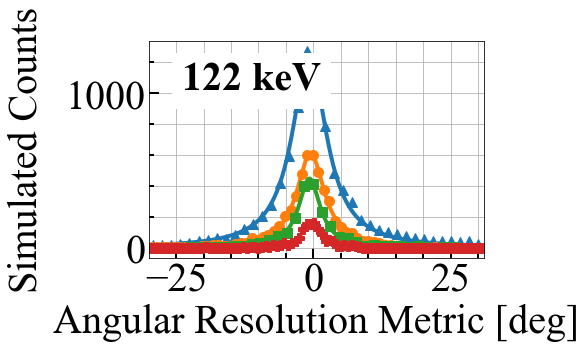

In [26]:
%matplotlib inline
font = FontProperties()
font.set_name('Times New Roman')
fig, ax = plt.subplots()
ax.set_xlabel('Angular Resolution Metric [deg]', fontsize=40, fontproperties=font)
ax.set_ylabel('Simulated Counts', fontsize=40, labelpad=20, fontproperties=font)
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='in', labelsize=40)
ax.tick_params(which='minor', length=5, width=2, direction='in')

ax.plot( reset, hist,'^', color='tab:blue', markersize=10, label='All Double-Interaction Events')
ax.plot(vals, lorenz_curve,'tab:blue', linewidth=4)

ax.plot( reset_theta , hist_theta, 'o', color='tab:orange', markersize=10, label='Scattering Angle Criterion Only')
ax.plot( vals, lorenz_curve_theta,'tab:orange', linewidth=4)

ax.plot( reset_lever , hist_lever,'s', color='tab:green', markersize=10, label='Lever Arm Criterion Only')
ax.plot( vals, lorenz_curve_lever,'tab:green', linewidth=4)

ax.plot( reset_both , hist_both, 'P', color='tab:red', markersize=10, label='Both Criteria')
ax.plot( vals, lorenz_curve_both,'tab:red', linewidth=4)

#ax.legend(prop={"family":"Times New Roman", 'size': 27}, loc='upper right', framealpha=1 )
ax.text(0.1, 0.9, '122 keV', transform=ax.transAxes, 
        fontsize=40, fontproperties=font, verticalalignment='top', 
        weight='bold', bbox=dict(facecolor='white', edgecolor='None', pad=10))
ax.set_xlim(-30, 31)
ax.grid(which='both')
for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
plt.show()

In [27]:
half = np.max(lorenz_curve) / 2
half_lever = np.max(lorenz_curve_lever) / 2
half_theta = np.max(lorenz_curve_theta) / 2
half_both = np.max(lorenz_curve_both) / 2

In [28]:
mask = ( lorenz_curve >= half )
mask_lever = ( lorenz_curve_lever >= half_lever )
mask_theta = ( lorenz_curve_theta >= half_theta )
mask_both = ( lorenz_curve_both >= half_both )

In [29]:
FWHM = np.abs( vals[mask][0] ) + np.abs( vals[mask][-1] )
FWHM_lever = np.abs( vals[mask_lever][0] ) + np.abs( vals[mask_lever][-1] )
FWHM_theta = np.abs( vals[mask_theta][0] ) + np.abs( vals[mask_theta][-1] )
FWHM_both = np.abs( vals[mask_both][0] ) + np.abs( vals[mask_both][-1] )

In [30]:
print(FWHM, FWHM_theta, FWHM_lever, FWHM_both)

7.703000000036781 6.131000000029275 4.827000000023048 3.967000000018942


In [31]:
solid = ( 74 * 74 ) / ( 4 * np.pi * 40 ** 2 + ( 2 * 74 * 74 ) )
sens = len( beta ) / ( 1000000  * solid )
sens_theta = len( beta_theta ) / ( 1000000  * solid )
sens_lever = len( beta_lever ) / ( 1000000  * solid )
sens_both = len( beta_both ) / ( 1000000  * solid )
print(sens, sens_theta, sens_lever, sens_both)

0.051039568782649584 0.031143268383768068 0.012216827553931237 0.008513211772725527


In [32]:
# reset_both2 = reset_both.copy()
# hist_both2 = hist_both.copy()
# vals2 = vals.copy()
# lorenz_curve_both2 = lorenz_curve_both.copy()

In [34]:
%matplotlib qt
font = FontProperties()
font.set_name('Times New Roman')
fig, ax = plt.subplots()
ax.set_xlabel('Angular Resolution Metric [deg]', fontsize=40, fontproperties=font)
ax.set_ylabel('Simulated Counts', fontsize=40, labelpad=20, fontproperties=font)
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='in', labelsize=40)
ax.tick_params(which='minor', length=5, width=2, direction='in')

ax.plot( reset_both, hist_both,'^', color='tab:orange', markersize=10, label='Strip Pitch = 0.5 mm')
ax.plot(vals, lorenz_curve_both,'tab:orange', linewidth=4)

ax.plot( reset_both2, hist_both2, 'P', color='tab:blue', markersize=10, label='Strip Pitch = 2 mm')
ax.plot( vals2, lorenz_curve_both2,'tab:blue', linewidth=4)

ax.legend(prop={"family":"Times New Roman", 'size': 35}, loc='upper right', framealpha=1 )
# ax.text(0.1, 0.9, '440 keV', transform=ax.transAxes, 
#         fontsize=40, fontproperties=font, verticalalignment='top', 
#         weight='bold', bbox=dict(facecolor='white', edgecolor='None', pad=10))
ax.set_xlim(-30, 31)
ax.grid(which='both')
for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
plt.show()